# Predicting Likelihood of Recidivism

## Ethan Stucky, Athian Camberos

### 12/16/2025

# Introduction

The data set includes database on incarcerated individuals who either re-committed crimes, or refrained from commiting crimes after their release. The goal is to predict whether the individual will recidivate within three years after their release. This report can be useful to re-examine the justice system and it's efficacy at reforming criminals. This data was collected from: https://drive.google.com/file/d/16eDrb_UoCSHvktAx5xdxUR-kwnnKVCYJ/view?usp=sharing On 12/9/2025


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def plot_learning_curve(clf, X_train, y_train):
    # generate the data; average the values
    train_sizes, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Learning curve, classification tree')
    plt.legend();

In [ ]:
def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """

    if classes is None:
        classes = ['neg', 'pos']

    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left       = '{:<10s}'.replace('10', str(n))
    right      = '{:>10s}'.replace('10', str(m))
    big_center = '{:^20s}'.replace('20', str(m*2))

    cm = confusion_matrix(y_true, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
sns.set_theme(context='notebook', style='whitegrid')

#Read the data

In [ ]:
url='https://drive.google.com/file/d/16eDrb_UoCSHvktAx5xdxUR-kwnnKVCYJ/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df=pd.read_csv(url)

#Initial exploration

We'll first get a list of all the variables in this dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 53 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 18028 non-null  int64  
 1   Gender                                             18028 non-null  object 
 2   Race                                               18028 non-null  object 
 3   Age_at_Release                                     18028 non-null  object 
 4   Residence_PUMA                                     18028 non-null  int64  
 5   Gang_Affiliated                                    15811 non-null  object 
 6   Supervision_Risk_Score_First                       17698 non-null  float64
 7   Supervision_Level_First                            16816 non-null  object 
 8   Education_Level                                    18028 non-null  object 
 9   Depend

Immediately, it's clear we have a long list to go through. Some quantitative variables, some descriptive data objects, and a lot of true or false variables. But before we start working on it, lets get a feel for who is in the data.

#Exploration and visualization


These initial plots are created to help give us an understanding of the characteristics of individuals in this data set that may help lead to identifying indictative predictors of recidivism. Starting with age distribution of individuals

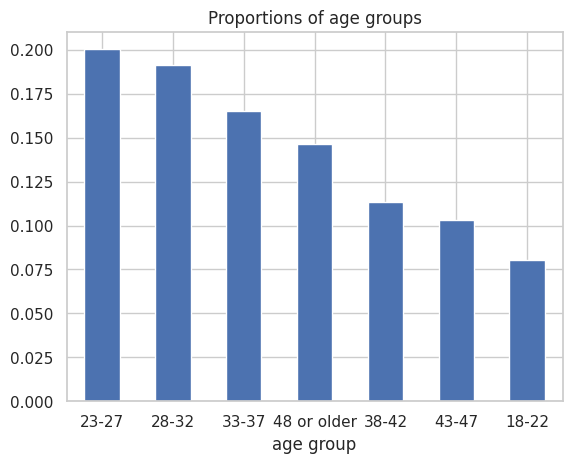

In [ ]:
df['Age_at_Release'].value_counts(normalize=True).plot.bar(rot=0)
plt.title('Proportions of age groups')
plt.xlabel('age group');


While there is a steady decrease in size of age group as age increases, surprisingly the youngest age group is the smallest. There may be special circumstances either with the younger group or lacking from this group.

Lets see how age groups compare to recidivism and see if there is any parallel.

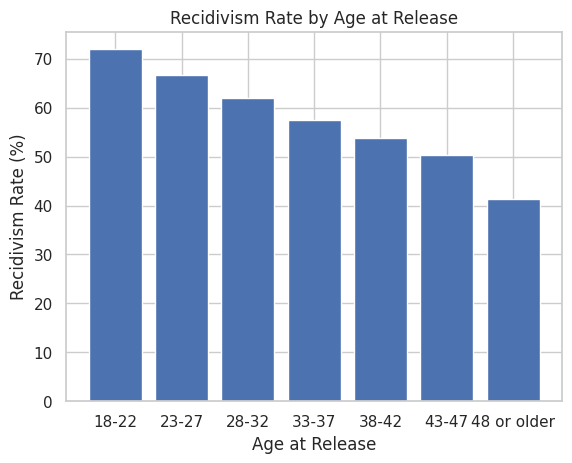

In [ ]:
age_order = ['18-22', '23-27', '28-32', '33-37', '38-42', '43-47', '48 or older']
recid_by_age = df.groupby('Age_at_Release')['Recidivism_Within_3years'].mean() * 100
recid_by_age = recid_by_age.reindex(age_order)

plt.bar(recid_by_age.index, recid_by_age.values)
plt.xlabel('Age at Release')
plt.ylabel('Recidivism Rate (%)')
plt.title('Recidivism Rate by Age at Release')
plt.xticks(rotation=0);

It looks like there is a potential negative correlation between recidivism and age. However, interestingly the youngest age group has the highest rate, while being the smallest in the data.

Now lets see what the proportions of recidivism by types of offenses.

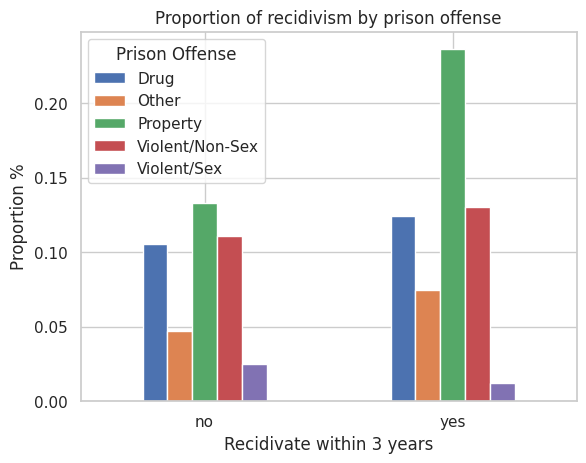

In [ ]:
pd.crosstab(df['Recidivism_Within_3years'], df['Prison_Offense'], normalize=True).plot.bar(rot=0)
plt.xlabel('Recidivate within 3 years')
plt.ylabel('Proportion %')
plt.title('Proportion of recidivism by prison offense')
plt.legend(title='Prison Offense')
plt.xticks([0, 1], ['no', 'yes'],);

An interesting outlier with the crimes in recidivism is nearly 1/4 are property related offenses.

Now that we have done a little exploring of the data set related to the recidivism rates, let's start working toward predicting outcomes with it.

# Initial preprocessing and cleaning

Before we do any work on our data itself, we should take a moment to consider what variables are useful.

While we have many variables to choose from for predictions, some of the variables would only ever be available after an individual was released.

Unfortunately by that point if someone is to recidivate, thus that post-release data is not very helpful to us.

So at least for now, we will remove any post-release variables and just focus on what we could know before someone is released.

Below is a list of post-release and irrelavent variables.

In [ ]:
post_release_columns = ['ID',
'Violations_ElectronicMonitoring',
'Violations_Instruction',
'Violations_FailToReport',
'Violations_MoveWithoutPermission',
'Delinquency_Reports',
'Program_Attendances',
'Program_UnexcusedAbsences',
'Residence_Changes',
'Avg_Days_per_DrugTest',
'DrugTests_THC_Positive',
'DrugTests_Cocaine_Positive',
'DrugTests_Meth_Positive',
'DrugTests_Other_Positive',
'Percent_Days_Employed',
'Jobs_Per_Year',
'Employment_Exempt',
'Recidivism_Arrest_Year1',
'Recidivism_Arrest_Year2',
'Recidivism_Arrest_Year3']

Next we drop those variables from the dataset.

In [ ]:
df.drop(columns=post_release_columns, inplace=True)

We have the variables we want to work with. Lets check to see if there is any missing data we need to address first.

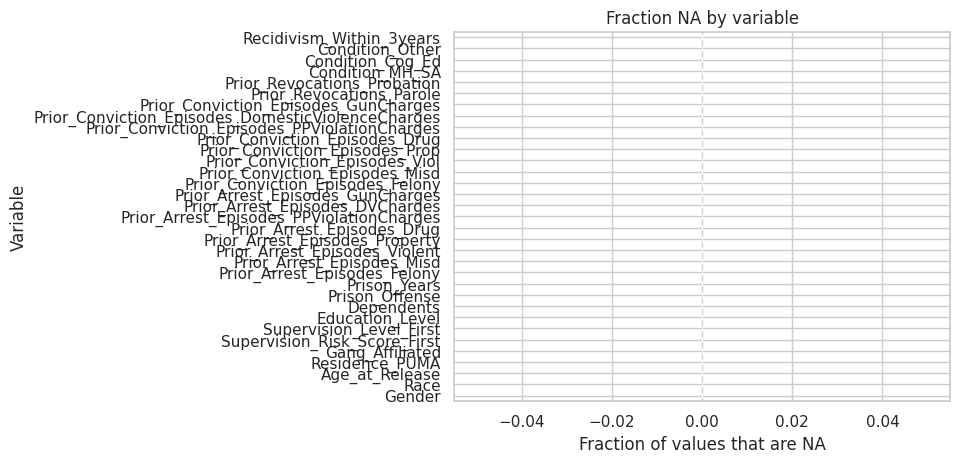

In [ ]:
df.isna().mean().sort_values().plot.barh()
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

Sure enough, there are several columns that contain missing data.

We will impute these with the columns modes

In [ ]:
modes = {c:df[c].value_counts().index[0]
	    for c in df.columns}
df.fillna(modes, inplace=True)


#Data preparation for machine learning



Next we'll reformat the variables for ML

In [ ]:
# encoding dictionaries
new_years = {'Less than 1 year': 0, '1-2 years': 1, 'Greater than 2 to 3 years': 2, 'More than 3 years': 3}
new_supervision = {'Standard': 0, 'High': 1, 'Specialized': 2}
new_education_levels = {'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2}
numeric_supervision = {'Standard': 0, 'High': 1, 'Specialized': 2}
two_or_more = {'2 or more': 2}
three_or_more = {'3 or more': 3}
four_or_more = {'4 or more': 4}
five_or_more = {'5 or more': 5}
six_or_more = {'6 or more': 6}
ten_or_more = {'10 or more': 10}
age_map = {
    '18-22': 0, '23-27': 1, '28-32': 2, '33-37': 3,
    '38-42': 4, '43-47': 5, '48 or older': 6
}


# Apply to columns
df['Gender'] = (df['Gender'] == 'F').astype(int)
df['Race'] = (df['Race'] == 'BLACK').astype(int)
df['Gang_Affiliated'] = (df['Gang_Affiliated'] == True).astype(int)
df['Age_at_Release'] = df['Age_at_Release'].replace(age_map).astype(int)
df['Education_Level'] = df['Education_Level'].replace(new_education_levels).astype(int)
df['Dependents'] = df['Dependents'].replace(three_or_more)
df['Dependents'] = df['Dependents'].astype(int)
df['Prison_Years'] = df['Prison_Years'].replace(new_years).astype(int)
df['Prior_Conviction_Episodes_Felony'] = df['Prior_Conviction_Episodes_Felony'].replace(three_or_more).astype(int)
df['Prior_Conviction_Episodes_Prop'] = df['Prior_Conviction_Episodes_Prop'].replace(three_or_more).astype(int)
df['Prior_Conviction_Episodes_Misd'] = df['Prior_Conviction_Episodes_Misd'].replace(four_or_more).astype(int)
df['Prior_Conviction_Episodes_Drug'] = df['Prior_Conviction_Episodes_Drug'].replace(two_or_more).astype(int)
df['Prior_Arrest_Episodes_Misd'] = df['Prior_Arrest_Episodes_Misd'].replace(six_or_more).astype(int)
df['Prior_Arrest_Episodes_Violent'] = df['Prior_Arrest_Episodes_Violent'].replace(three_or_more).astype(int)
df['Prior_Arrest_Episodes_Property'] = df['Prior_Arrest_Episodes_Property'].replace(five_or_more).astype(int)
df['Prior_Arrest_Episodes_Drug'] = df['Prior_Arrest_Episodes_Drug'].replace(five_or_more).astype(int)
df['Prior_Arrest_Episodes_PPViolationCharges'] = df['Prior_Arrest_Episodes_PPViolationCharges'].replace(five_or_more).astype(int)
df['Prior_Arrest_Episodes_Felony'] = df['Prior_Arrest_Episodes_Felony'].replace(ten_or_more).astype(int)
df['Supervision_Level_First'] = df['Supervision_Level_First'].replace(numeric_supervision)

df = pd.get_dummies(df, columns=['Prison_Offense'])

Now lets check the types to make sure all are not objects and are sci-kit learn friendly

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18028 entries, 0 to 18027
Data columns (total 37 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Gender                                             18028 non-null  int64  
 1   Race                                               18028 non-null  int64  
 2   Age_at_Release                                     18028 non-null  int64  
 3   Residence_PUMA                                     18028 non-null  int64  
 4   Gang_Affiliated                                    18028 non-null  int64  
 5   Supervision_Risk_Score_First                       18028 non-null  float64
 6   Supervision_Level_First                            18028 non-null  int64  
 7   Education_Level                                    18028 non-null  int64  
 8   Dependents                                         18028 non-null  int64  
 9   Prison

With only bool, int, and float variables left, we can begin the machine learning.

#Machine learning



### Set predictor and target variables

In [ ]:
target = 'Recidivism_Within_3years'
predictors = df.columns.drop([target])
X = df[predictors].values
y = df[target].values

### Scale the data

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Perform train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Get most common target output:

In [ ]:
vals, counts = np.unique(y_train, return_counts=True)
target_mode = vals[counts.argmax()]
print('Most common target value: {}'.format(target_mode))

Most common target value: True


So the most common outcome is recidivating.

### Compute baseline accuracy

In [ ]:
base_accuracy = ((target_mode == y_train).mean() * 100).round()

print(f'Baseline accuracy: {base_accuracy}%')


Baseline accuracy: 57.0%


Just guessing the most common outcome is nearly a coin flip, can we do better?

Now because our target variable is either true or false, we'll be using classification models.

We'll start with K nearest neighbors.

### Define and fit a default classifier

In [ ]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
train_accuracyCV = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10).mean()
score = (train_accuracyCV * 100).round(2)
print(f'Cross-validation accuracy: {score}%')

Cross-validation accuracy: 61.25%


With just using the default KNN, we get about a 4% improvement.

Lets use a grid search to find the best parameters for neighbors and the distance function.

In [ ]:
# P: 1 is manhattan, and 2 is euclidean distance.
grid = {'n_neighbors': range(50,100, 2), 'p': [1,2]}

knnCV = GridSearchCV(KNeighborsClassifier(), grid, cv=5, scoring='accuracy')
knnCV.fit(X_train, y_train)
score = (knnCV.best_score_ * 100).round(2)

In [ ]:
print(f"Best parameters: {knnCV.best_params_}")
print(f"Best score: {score}%")

Best parameters: {'n_neighbors': 66, 'p': 1}
Best score: 66.35%


This is good news! We have already made an improvement from 57% baseline to 66% with the best parameters. Though we are using all of our predictor variables, maybe we can get a better score with the best features.

Lets retrain a model first with the best performing model from the gridsearch.

In [ ]:
clf = knnCV.best_estimator_

Now let's find the best features

In [ ]:
selector = SequentialFeatureSelector(clf,
n_features_to_select=6, cv=5)

selector.fit(X_train, y_train)
feature_mask = selector.get_support()
best_features = pd.Series(predictors[feature_mask])

KeyboardInterrupt: 

In [ ]:
print(f'Best features selected: \n{best_features}')

Then reclassify with our best predictors.

In [ ]:
X = df[predictors].values
scaler.fit_transform(X);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
# P: 1 is manhattan, and 2 is euclidean distance.
grid = {'n_neighbors': range(40,80, 2), 'p': [1,2]}

knnCV = GridSearchCV(KNeighborsClassifier(), grid, cv=5, scoring='accuracy')
knnCV.fit(X_train, y_train)
score = (knnCV.best_score_ * 100).round(2)


In [ ]:
print(f"Best parameters: {knnCV.best_params_}")
print(f"Best score: {score}%")

Best parameters: {'n_neighbors': 48, 'p': 1}
Best score: 66.34%


It appears that focusing on our best features did not produce a meaningful improvement.

let's plot a learning curve to see how the set size affects our accuracy.

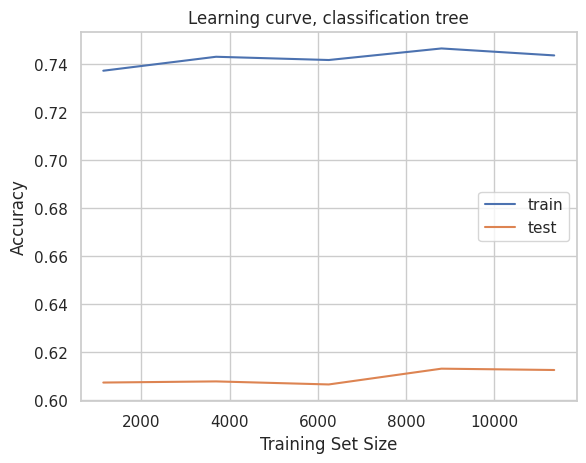

In [ ]:
plot_learning_curve(clf, X_train, y_train)

Judging by the gap between the lines, we have some variance with KNN. Now let's try using a different model. A logistic regression.

### Define and fit regression

In [ ]:
regr = LogisticRegression()
regr.fit(X_train, y_train)

LogisticRegression()

Let's see how each variable is contributing to recidivism.

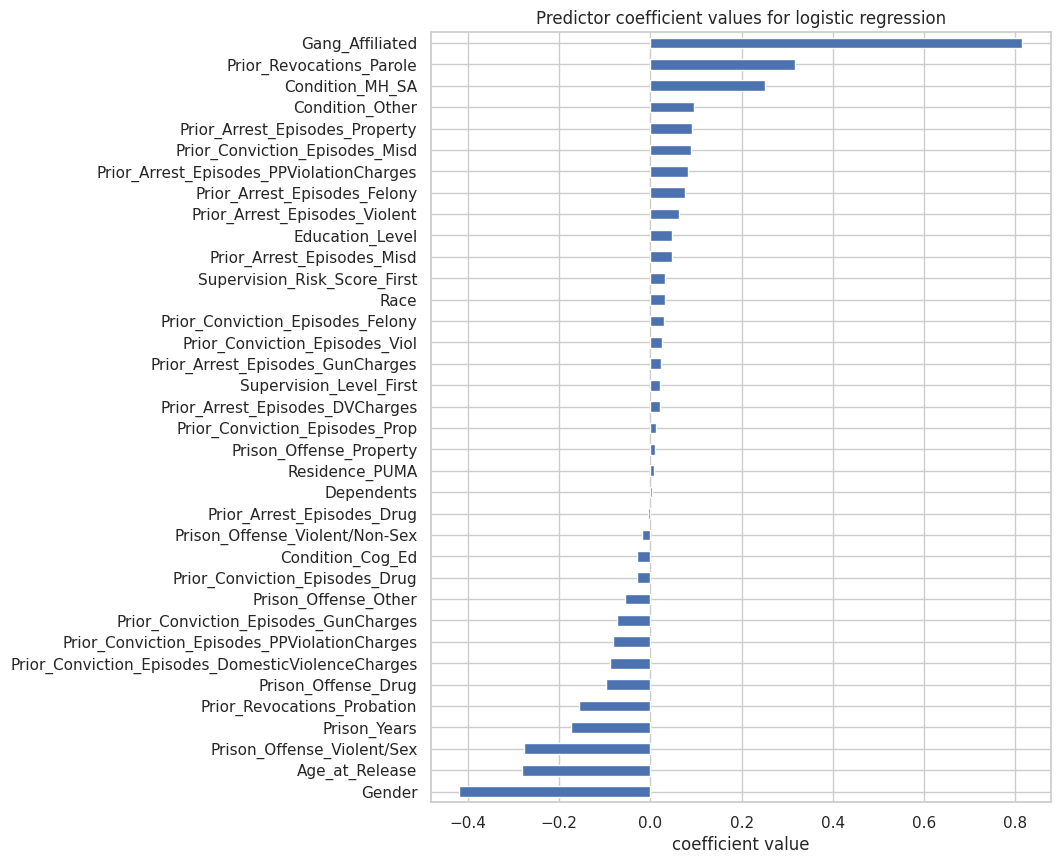

In [ ]:
coefficients = pd.DataFrame(zip(predictors, regr.coef_[0]), columns =['Feature', 'Coefficient'])
coefficients.set_index('Feature', inplace=True)

plt.figure(figsize=(8, 10))
coefficients = coefficients.sort_values(by='Coefficient', ascending=True)
coefficients['Coefficient'].plot.barh().set_title('Predictor coefficient values for logistic regression')
plt.ylabel('')
plt.xlabel('coefficient value')
plt.show()


Somewhat unsurprising, gang affiliation heavily weighs toward recidivism, whereas age and gender weighs negatively.

Let's plot another learning curve to see how the regression is doing.

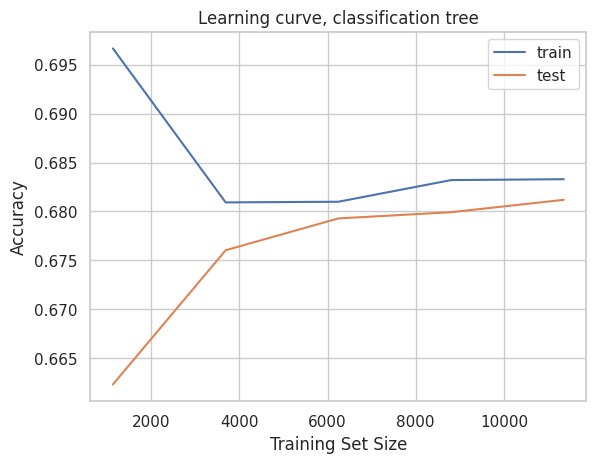

In [ ]:
plot_learning_curve(regr, X_train, y_train)


Now there is much less variance with the regression.

In [ ]:
y_pred = cross_val_predict(regr, X_train, y_train, cv=5)

In [ ]:
print_conf_mtx(y_train, y_pred, classes=['Not recidivate', 'Recidivate'])

                       predicted          
actual        Not recidivate    Recidivate
Not recidivate          2831          2580
Recidivate              1450          5758


### Finally predict with the test set

In [ ]:
# Predict target values and calculate accuracy
y_pred = regr.predict(X_test)
log_accuracy = ((y_pred == y_test).mean() * 100).round(2)
print(f"Logistic regression test accuracy: {log_accuracy}%")

Logistic regression test accuracy: 68.83%


#Conclusions

Using what was gathered using visualizations and machine learning it seems that it is likely an inmate will re offend.

Our baseline accuracy was 57.1%.

The outcome of this means that guessing each inmate would recidivate would be accurate around 57% of the time.

We also tested two machine learning algorithms. Using KNN it achieved 66% accuracy, which surpassed the baselinee using 48 neighbors with Manhattan distance.

With logistic regression it predicted around 68% accuracy.

With research and machine learning algorithms, it can be concluded that over half of inmates will recidivate within three years after their release.